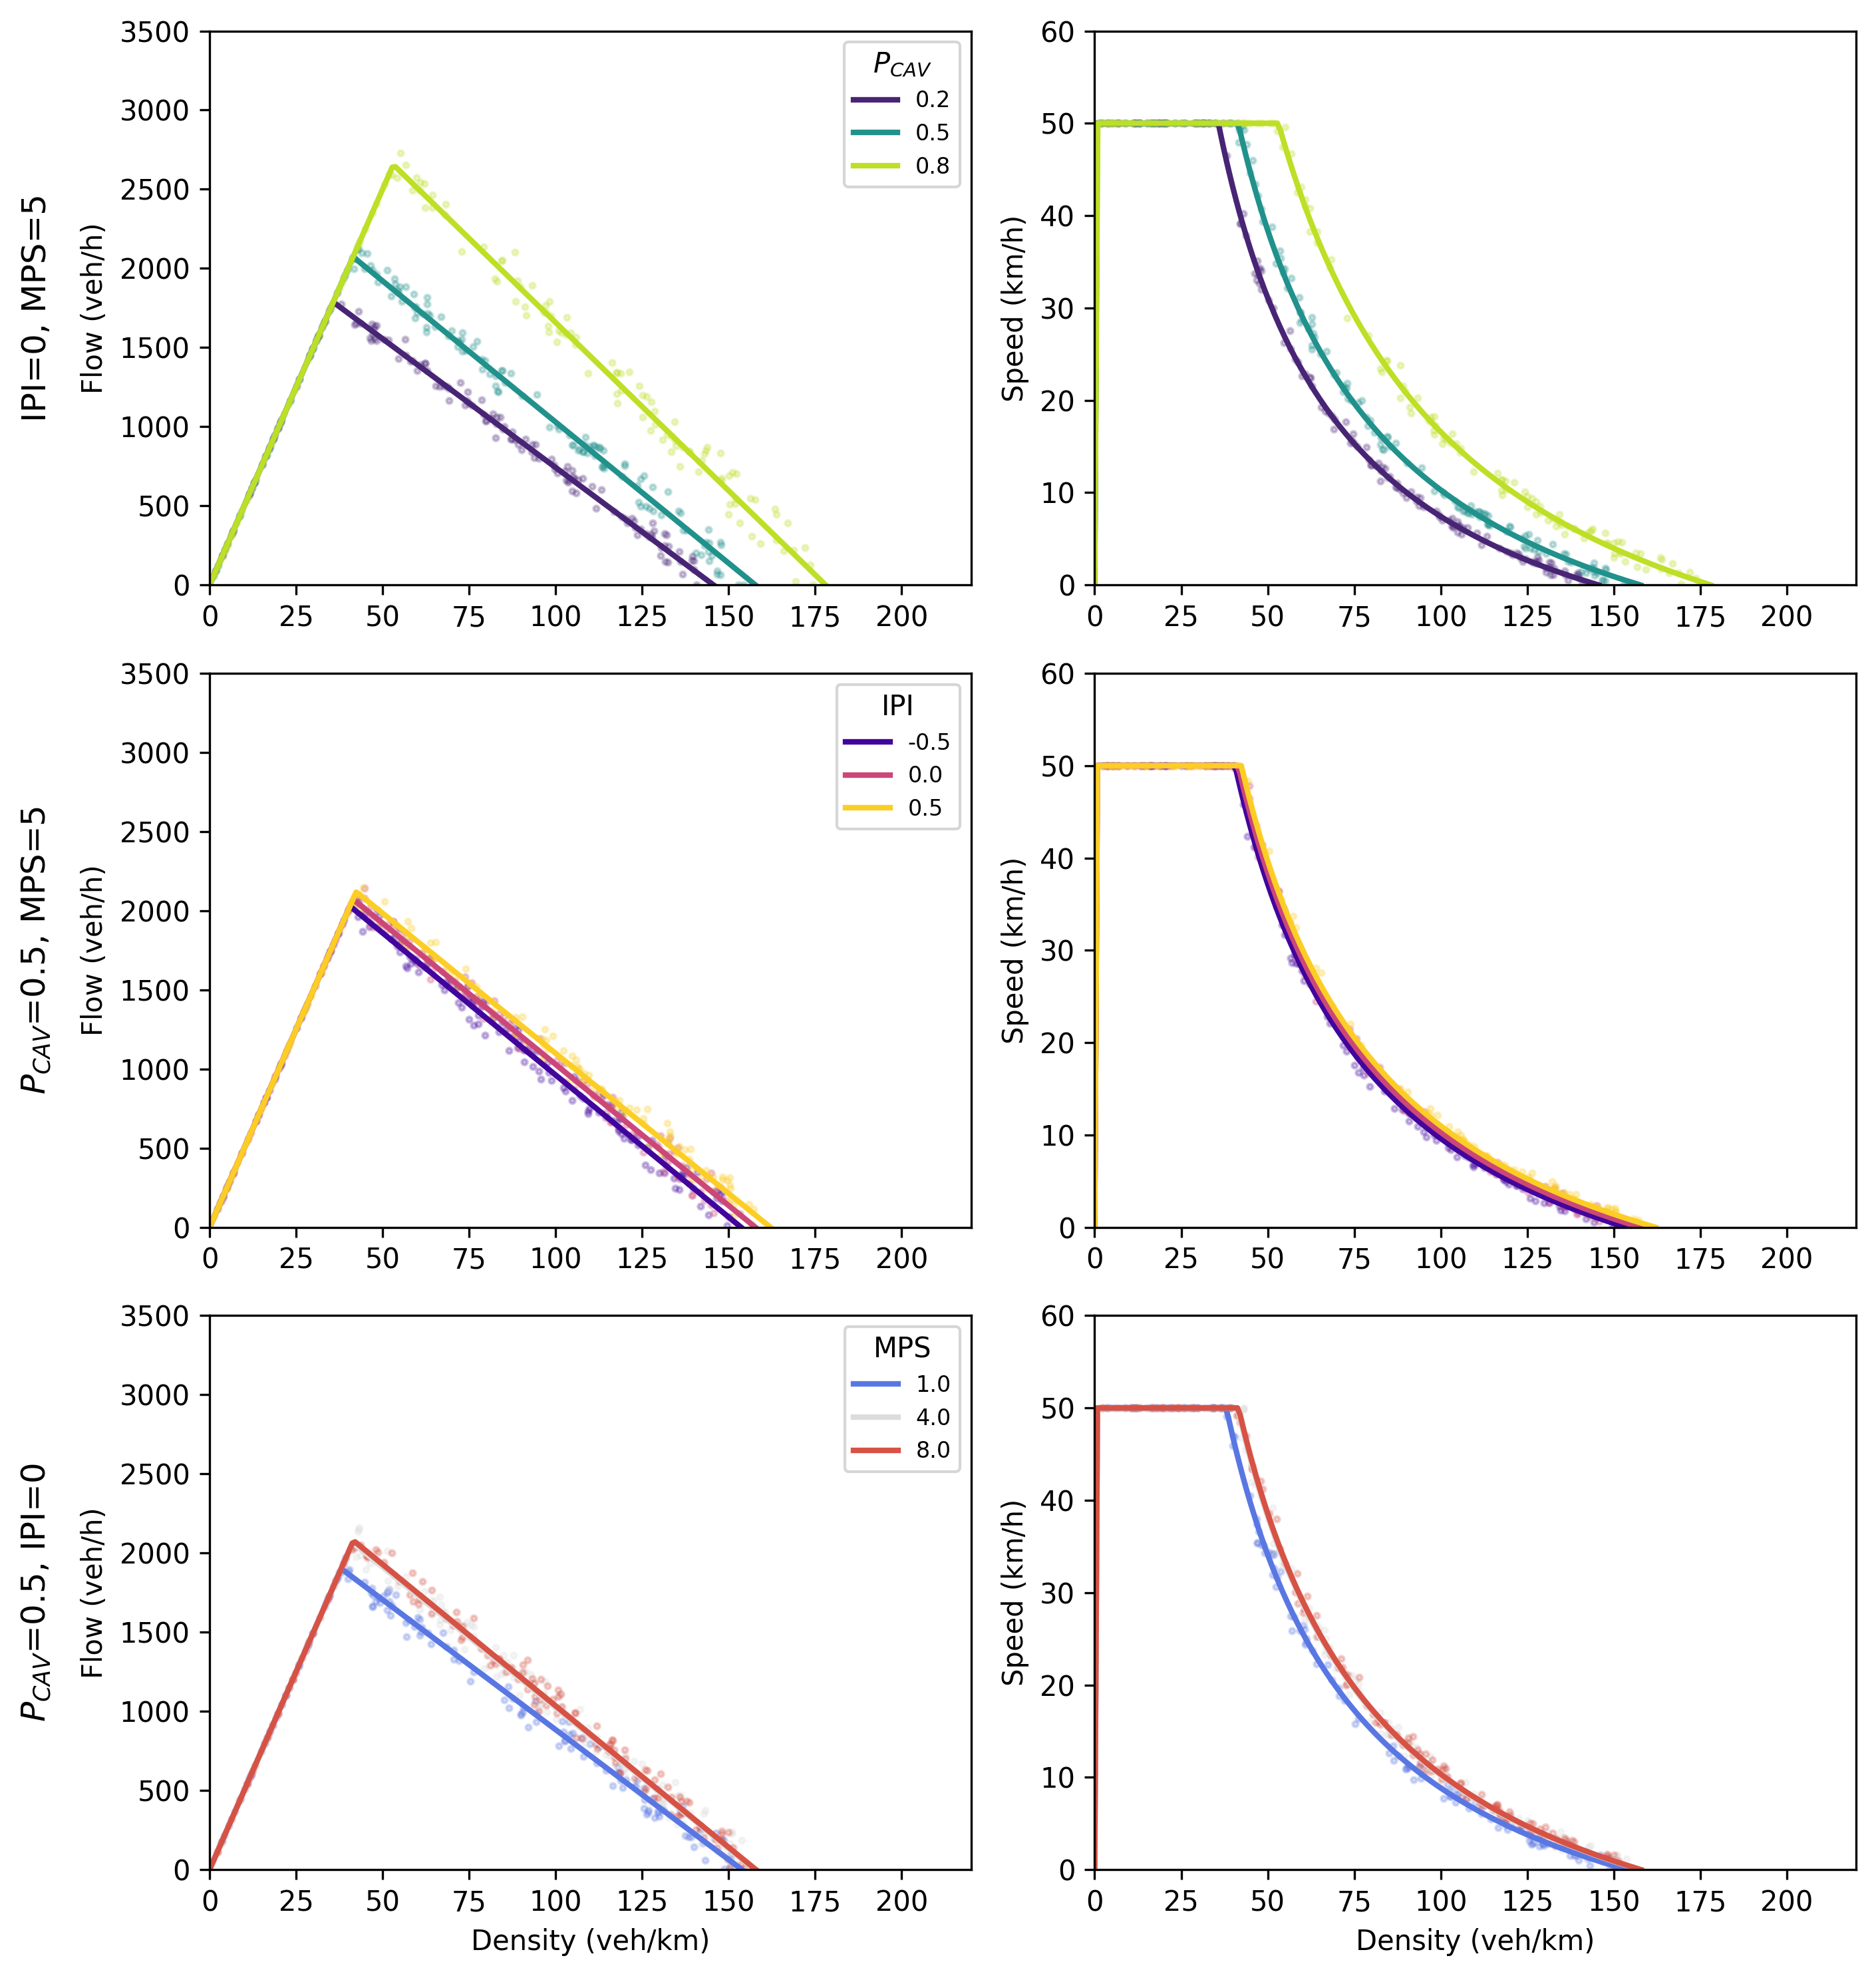

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. 基础参数与函数 (保持不变)
# ==========================================
v_f = 50.0  # free-flow speed (km/h)

d_nominal = {'HV_HV': 7.0, 'plt_HV': 7.0, 'HV_plt': 7.0, 'plt_plt': 5.0, 'CAV_CAV': 5.0}
tau_nominal = {'HV_HV': 1.60, 'plt_HV': 1.50, 'HV_plt': 1.50, 'plt_plt': 1.10, 'CAV_CAV': 0.60}

def compute_P0(P, L):
    if P == 1: return 0
    return (1 - P**L) / (1 - P**L + P)

def get_params(P, L, gamma, noise_scale=0.0):
    P0 = compute_P0(P, L)

    w_hv_hv = (1 - P) * (gamma*(1-P0) + P0)
    w_hetero = (1 - P) * (1-P0)*(1-gamma)
    w_plt_plt = (1 - P)/P0 * (1-P0)*(gamma*P0 + 1-P0)
    w_cav_cav = 1 - (1 - P)/P0

    d_agg = w_hv_hv*d_nominal['HV_HV'] + w_hetero*(d_nominal['plt_HV'] + d_nominal['HV_plt']) + \
            w_plt_plt*d_nominal['plt_plt'] + w_cav_cav*d_nominal['CAV_CAV']

    tau_agg = w_hv_hv*tau_nominal['HV_HV'] + w_hetero*(tau_nominal['plt_HV'] + tau_nominal['HV_plt']) + \
              w_plt_plt*tau_nominal['plt_plt'] + w_cav_cav*tau_nominal['CAV_CAV']

    if noise_scale > 0:
        r_d = np.random.uniform(1 - noise_scale, 1 + noise_scale)
        r_t = np.random.uniform(1 - noise_scale, 1 + noise_scale)
        return d_agg * r_d, tau_agg * r_t
    else:
        return d_agg, tau_agg

def get_curve(P, L, gamma):
    bar_d, bar_tau = get_params(P, L, gamma, noise_scale=0)
    D = bar_d / 1000.0
    T = bar_tau / 3600.0
    Kj = 1.0 / D
    Kc = 1.0 / (D + v_f * T)

    k_vals = np.linspace(0, Kj, 200)
    q_vals = []
    for k in k_vals:
        if k <= Kc: q = v_f * k
        else: q = (1.0/T) - (D/T)*k
        q_vals.append(max(0, q))

    q_vals = np.array(q_vals)
    with np.errstate(divide='ignore', invalid='ignore'):
        v_vals = np.divide(q_vals, k_vals)
        v_vals[k_vals<=0.01] = v_f
        v_vals[q_vals<=0] = 0

    return k_vals, q_vals, v_vals

def generate_scatter(P, L, gamma, num_points=150, noise=0.05):
    d_base, _ = get_params(P, L, gamma, 0)
    Kj_base = 1000.0 / d_base

    k_scatter = []
    q_scatter = []
    v_scatter = []

    for _ in range(num_points):
        k = np.random.uniform(1, Kj_base * 0.98)
        b_d, b_t = get_params(P, L, gamma, noise_scale=noise)
        D = b_d / 1000.0
        T = b_t / 3600.0
        Kc = 1.0 / (D + v_f * T)

        if k <= Kc:
            q = v_f * k
        else:
            q = (1.0/T) - (D/T)*k

        if q < 0: q = 0

        k_scatter.append(k)
        q_scatter.append(q)
        v_scatter.append(q/k if k>0 else 0)

    return k_scatter, q_scatter, v_scatter

# ==========================================
# 2. 绘图配置 (更新后)
# ==========================================
fig, axes = plt.subplots(3, 2, figsize=(10, 10), dpi=300)

noise_level = 0.05
scatter_alpha = 0.25
scatter_size = 4

# --- Row 1: Vary P_CAV ---
# Fixed: IPI=0, MPS=5
L_fix, I_fix = 5, 0
p_vals = [0.2, 0.5, 0.8]
# Use viridis colormap for gradient
cmap_p = plt.cm.viridis
colors_p = cmap_p(np.linspace(0.1, 0.9, len(p_vals)))

for p, c in zip(p_vals, colors_p):
    k, q, v = get_curve(p, L_fix, I_fix)
    axes[0,0].plot(k, q, color=c, linewidth=2, label=f'{p:.1f}')
    axes[0,1].plot(k, v, color=c, linewidth=2)

    ks, qs, vs = generate_scatter(p, L_fix, I_fix, num_points=150, noise=noise_level)
    axes[0,0].scatter(ks, qs, color=c, s=scatter_size, alpha=scatter_alpha, marker='o')
    axes[0,1].scatter(ks, vs, color=c, s=scatter_size, alpha=scatter_alpha, marker='o')

axes[0,0].set_ylabel('Flow (veh/h)')
axes[0,1].set_ylabel('Speed (km/h)')
axes[0,0].legend(loc='upper right', fontsize=8, title="$P_{CAV}$")

# --- Row 2: Vary IPI ---
# Fixed: P_CAV=0.5, MPS=5
P_fix, L_fix = 0.5, 5
i_vals = [-0.5, 0.0, 0.5]
# Use plasma colormap for gradient
cmap_i = plt.cm.plasma
colors_i = cmap_i(np.linspace(0.1, 0.9, len(i_vals)))

for i, c in zip(i_vals, colors_i):
    k, q, v = get_curve(P_fix, L_fix, i)
    axes[1,0].plot(k, q, color=c, linewidth=2, label=f'{i:.1f}')
    axes[1,1].plot(k, v, color=c, linewidth=2)

    ks, qs, vs = generate_scatter(P_fix, L_fix, i, num_points=150, noise=noise_level)
    axes[1,0].scatter(ks, qs, color=c, s=scatter_size, alpha=scatter_alpha)
    axes[1,1].scatter(ks, vs, color=c, s=scatter_size, alpha=scatter_alpha)

axes[1,0].set_ylabel('Flow (veh/h)')
axes[1,1].set_ylabel('Speed (km/h)')
axes[1,0].legend(loc='upper right', fontsize=8, title="IPI")

# --- Row 3: Vary MPS ---
# Fixed: P_CAV=0.5, IPI=0
P_fix, I_fix = 0.5, 0
l_vals = [1, 4, 8]
# Use coolwarm colormap for gradient
cmap_l = plt.cm.coolwarm
colors_l = cmap_l(np.linspace(0.1, 0.9, len(l_vals)))

for l, c in zip(l_vals, colors_l):
    k, q, v = get_curve(P_fix, l, I_fix)
    axes[2,0].plot(k, q, color=c, linewidth=2, label=f'{l:.1f}')
    axes[2,1].plot(k, v, color=c, linewidth=2)

    ks, qs, vs = generate_scatter(P_fix, l, I_fix, num_points=150, noise=noise_level)
    axes[2,0].scatter(ks, qs, color=c, s=scatter_size, alpha=scatter_alpha)
    axes[2,1].scatter(ks, vs, color=c, s=scatter_size, alpha=scatter_alpha)

axes[2,0].set_ylabel('Flow (veh/h)')
axes[2,1].set_ylabel('Speed (km/h)')
axes[2,0].set_xlabel('Density (veh/km)')
axes[2,1].set_xlabel('Density (veh/km)')
axes[2,0].legend(loc='upper right', fontsize=8, title="MPS")

# --- Global Layout ---
# 移除网格
for ax in axes.flat:
    ax.grid(False)
    ax.set_xlim(0, 220)
    if ax in axes[:,0]: ax.set_ylim(0, 3500)
    if ax in axes[:,1]: ax.set_ylim(0, 60)

# 添加行标题 (Suptitle替代方案)
# 通过在每行的左侧添加文本来实现行标题效果
pad = 10
axes[0,0].annotate("IPI=0, MPS=5", xy=(0, 0.5), xytext=(-pad, 0),
                xycoords=axes[0,0].yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center', rotation=90)

axes[1,0].annotate("$P_{CAV}$=0.5, MPS=5", xy=(0, 0.5), xytext=(-pad, 0),
                xycoords=axes[1,0].yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center', rotation=90)

axes[2,0].annotate("$P_{CAV}$=0.5, IPI=0", xy=(0, 0.5), xytext=(-pad, 0),
                xycoords=axes[2,0].yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center', rotation=90)

plt.tight_layout(rect=[0.05, 0, 1, 1]) # 留出左侧空间给行标题
plt.show()